<a href="https://colab.research.google.com/github/BrnCode/Previsao_Alugueis_Bicicletas_Series_Temporais/blob/main/Modelo_locacoes_de_bicicletas_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 - Modelagem de dados para Prophet:

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/BrnCode/Previsao_Alugueis_Bicicletas_Series_Temporais/bicicletas.csv")
df.head()

,data_hora,contagem,temperatura,sensacao_termica,umidade,velocidade_vento,clima,feriado,fim_de_semana,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,Nublado,Não,Sim,Inverno
1,2015-01-04 01:00:00,138,NaN,NaN,93.0,5.0,Céu limpo,Não,Sim,Inverno
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,Céu limpo,Não,Sim,Inverno
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,Céu limpo,Não,Sim,Inverno
4,2015-01-04 04:00:00,47,NaN,NaN,93.0,6.5,Céu limpo,Não,Sim,Inverno


In [ ]:
df = df.rename(columns={'data_hora':'data'})

# Convertendo a coluna 'data' para o tipo datetime
df['data'] = pd.to_datetime(df['data'])

# Formatando a coluna 'data' para exibir apenas 'YYYY-MM-DD'
df['data'] = df['data'].dt.strftime('%Y-%m-%d')

In [ ]:
df = df[['data', 'contagem']].rename(columns={'data':'ds', 'contagem':'y'})
df.head()

,ds,y
0,2015-01-04,182
1,2015-01-04,138
2,2015-01-04,134
3,2015-01-04,72
4,2015-01-04,47


Como originalmente nós tinhamos varios horarios por data, agora temos varias datas iguais com valores **y** diferentes. Vamos agrupar as datas!

In [ ]:
df = df.groupby('ds')['y'].sum().reset_index()
df

,ds,y
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
725,2016-12-30,11566
726,2016-12-31,11424
727,2017-01-01,6421
728,2017-01-02,11823


## Construindo modelo

Semente aleatoria do modelo

In [ ]:
np.random.seed(42)

In [ ]:
# Separando os últimos 40 dados para teste
train_df = df[:584]
test_df = df[584:]

In [ ]:
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

<ipython-input-116-727418f65ff9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ds'] = pd.to_datetime(train_df['ds'])
<ipython-input-116-727418f65ff9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])


In [ ]:
model_prophet = Prophet()

model_prophet.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/d_l9s51p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/0huznhl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77757', 'data', 'file=/tmp/tmplib0al6k/d_l9s51p.json', 'init=/tmp/tmplib0al6k/0huznhl3.json', 'output', 'file=/tmp/tmplib0al6k/prophet_model3s1ab3y1/prophet_model-20240602131935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prevendo informações

In [ ]:
# Fazendo previsões para o período de teste
futuro = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')
previsao = model_prophet.predict(futuro)

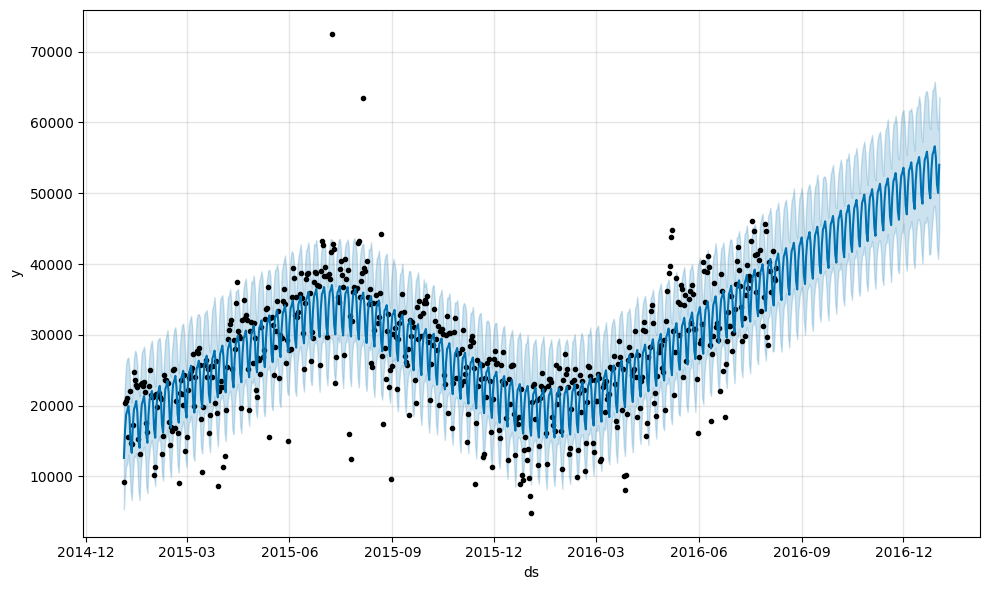

In [ ]:
fig1 = model_prophet.plot(previsao)

Os pontos pretos são equivalentes ao ultimo grafico de linha que plotamos, os valores reais, note os picos no segundo semestre de 2015. A linha azul escura é a nossa previsão.Essa faixa azul mais clara que envolve a linha azul escura, é o intervalo de confiança da nossa previsão. Ao fim dos pontos pretos, temos o inicio dos nossos dados que são apenas previsão.

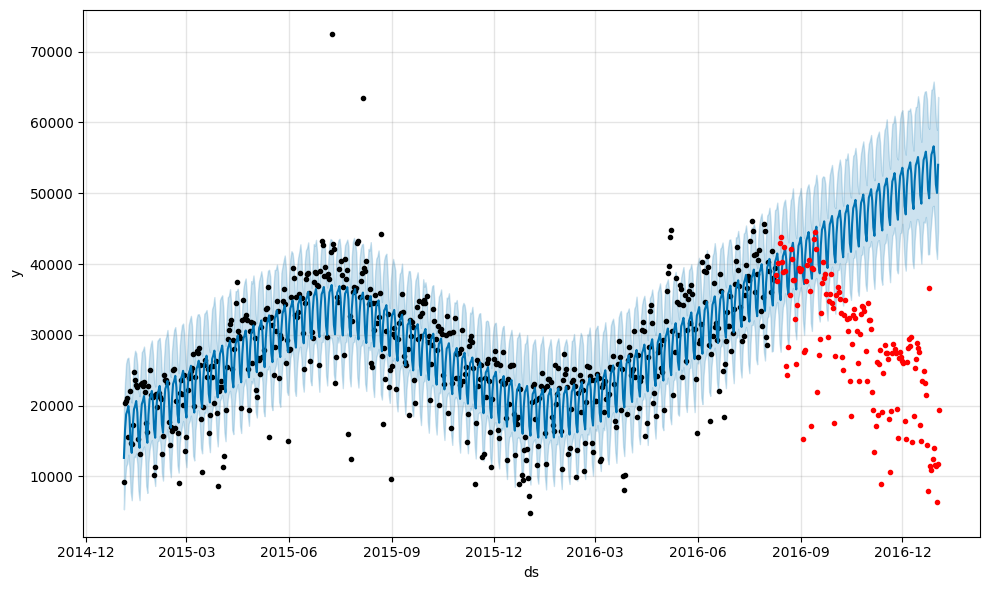

In [ ]:
fig1 = model_prophet.plot(previsao)
plt.plot(test_df['ds'], test_df['y'], '.r', label='Test Data')

plt.show()

Com a separação de treino e teste, o prophet não conseguiu entender a sazonalidade anual e interpretou os dados de forma que a previsão apresenta um alta que não condiz com os nossos dados de teste.

In [ ]:
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] # yhat é o nosso y predito, o lower é o limite inferior
                                                     # do intervalo de confiança e o upper o limite superior.

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-04,12620.077233,5352.780100,19538.290276
1,2015-01-05,16592.385323,9398.592322,23354.965545
2,2015-01-06,18778.297856,11422.332864,25959.492695
3,2015-01-07,19258.012635,11819.719527,26655.234738
4,2015-01-08,19938.755570,13070.963085,26778.207252
...,...,...,...,...
725,2016-12-29,56632.330689,48230.903601,65777.735455
726,2016-12-30,55029.410176,45996.252437,63778.597071
727,2016-12-31,51249.326104,42325.129089,60264.648927
728,2017-01-01,50044.909611,40719.227470,58962.035246


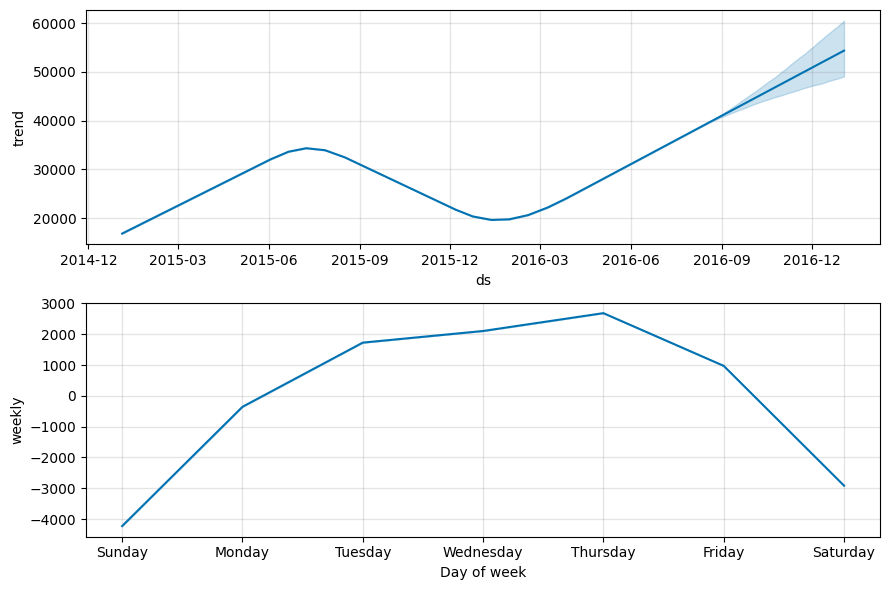

In [ ]:
fig2 = model_prophet.plot_components(previsao)

O primeiro grafico, de tren por ds, mostra o comportamento da tendencia dos dados no decorrer dos dias. É possivel ver uma tendencia de alta no final dos dias, o que não condiz com o que observamos nas analises e vemos que não existe tanta confiança que vai ser constante, pois a medida que nos afastamos do inicio da predição, o intervalos de confiança superior e inferior crescem.

Já o segundo grafico, weekly por Day of week, esse nos indica a sazonalidade semanal, que conversa muito com a analise que fizemos previamente de que em dias de semana, existe um pico de alugueis, logo é natural que nosso pico seja em torno do meio da semana e as nossas baixas sejam aos finais de semana, nas bordas.

E foram essas as componentes que o Prophet utilizou para fazer a predição que viamos acima.

Entendendo a performance do modelo com métricas

Com séries temporais costuma-se usar o MSE (Erro Quadrático Médio) e o RMSE (Raiz do Erro Quadrático Médio), por 3 motivos essencialmente:

* Medem Precisão: Avaliam a precisão do modelo, indicando o quão próximos os valores previstos estão dos valores reais.
* Penalizam Erros Grandes: Penalizam fortemente erros grandes devido à elevação ao quadrado dos erros, ajudando a detectar grandes discrepâncias.
* Interpretação Fácil: O RMSE está na mesma unidade dos dados originais, facilitando a interpretação dos erros.

In [ ]:
df_previsao = previsao[['ds', 'yhat']]

df_comparacao = pd.merge(df_previsao, test_df, on='ds')
df_comparacao.head()

,ds,yhat,y
0,2016-08-10,40802.805606,38430
1,2016-08-11,41490.013195,37626
2,2016-08-12,39887.092682,40159
3,2016-08-13,36107.008610,43041
4,2016-08-14,34902.592117,43848


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE:{mse}, RMSE:{rmse}')

MSE:473526727.94767874, RMSE:21760.669289975405


Temos um MSE com um valor astronomico, como esperado pelo erro que vimos. Mas nessa situação o RMSE acaba sendo mais util para entender o que houve, temos um erro de 21 mil bicicletas locadas, para mais e para menos.

Com isso nós temos nosso modelo baseline, que vai nos servir de referencia para entender se as nossas investigações de melhorias estão sendo efetivas.

## Melhorando o modelo

In [ ]:
np.random.seed(42)

### Melhorando modelo com uso de 1 hiperparametro

Na ultima previsão que fizemos, o prophet não conseguiu identificar a sazonalidade anuel, logo, iremos ativar "manualmente" através do hiperparametro **yearly_seasonality**

In [ ]:
model_prophet = Prophet(yearly_seasonality=True)

model_prophet.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/yo292iud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/rhajzhg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8700', 'data', 'file=/tmp/tmplib0al6k/yo292iud.json', 'init=/tmp/tmplib0al6k/rhajzhg3.json', 'output', 'file=/tmp/tmplib0al6k/prophet_modeli15h16dq/prophet_model-20240602131938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Fazendo previsões para o período de teste
futuro = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')
previsao = model_prophet.predict(futuro)

In [ ]:
# Avaliando MSE e RMSE

df_previsao = previsao[['ds', 'yhat']]

df_comparacao = pd.merge(df_previsao, test_df, on='ds')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE:{mse}, RMSE:{rmse}')

MSE:38211313.258375496, RMSE:6181.530009502138


Tivemos um diminuição significativa de erro, especialmente do RMSE que é o erro que nos mostra a melhoria em escala, então agora, temos um erro de 6 mil bicicletas alugadas pra cima e para baixo

In [ ]:
# Calcular a média dos valores reais no conjunto de teste
mean_real_values = test_df['y'].mean()

# Calcular o RMSE (já calculado)
rmse = 6181.530009502138

# Calcular o erro percentual médio
mpe = (rmse / mean_real_values) * 100

print(f'Média dos valores reais: {mean_real_values}')
print(f'Erro Percentual Médio (MPE): {mpe:.2f}%')

Média dos valores reais: 28324.30821917808
Erro Percentual Médio (MPE): 21.82%


Com um erro percentual médio de 21,82%, a precisão das previsões torna-se significativamente mais interessante e confiável.

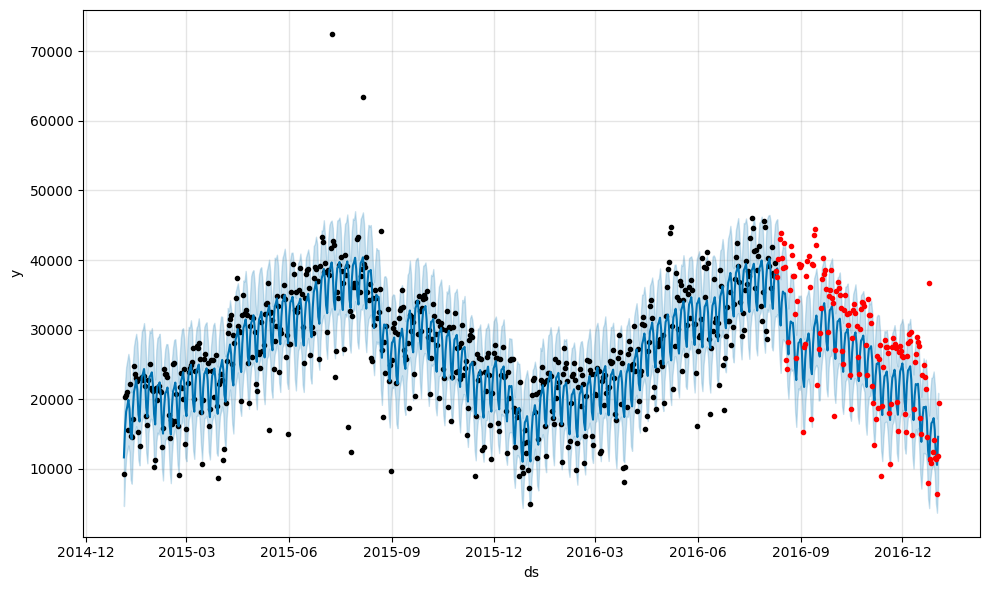

In [ ]:
fig1 = model_prophet.plot(previsao)
plt.plot(test_df['ds'], test_df['y'], '.r', label='Test Data')

plt.show()

Visualmente também é muito mais precisa.

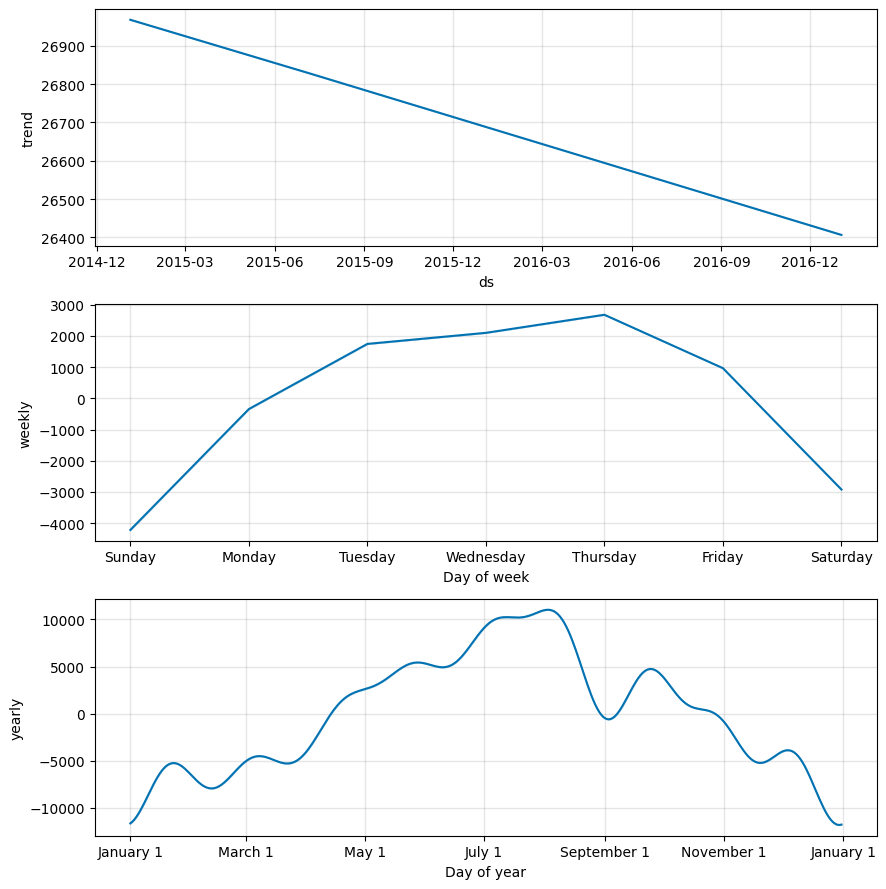

In [ ]:
fig2 = model_prophet.plot_components(previsao)

Agora os graficos das componentes usadas para construir o modelo estão muito mais proximos as nossas analises:

* A tendencia sazonal está caindo, o que conversa bastante com o momento que está sendo previsto, que é de uma queda caracteristica do segundo semestre;
* O grafico de Week por Day of Week continua o mesmo e com a mesma descrição da ultima analise de componentes;
* E a nossa grande novidade e motivo de nossa melhoria consideravel do modelo, a avaliação de uma sazonalidade anual, que conversa com nossa analise exploratória, onde no verão (meio do ano na Europa), temos o pico do ano e uma queda nas extremidades que representam começo e fim de ano.

### Retirando os outliers que estão fora do limite inferior e superior de confiança

In [ ]:
modelo = Prophet()
modelo.fit(df)
futuro = modelo.make_future_dataframe(periods=0)
previsao = modelo.predict(futuro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/2mswup2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/0qznyebx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88504', 'data', 'file=/tmp/tmplib0al6k/2mswup2e.json', 'init=/tmp/tmplib0al6k/0qznyebx.json', 'output', 'file=/tmp/tmplib0al6k/prophet_model21eqz0x2/prophet_model-20240602131949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
sem_outliers = df[(df['y'] > previsao['yhat_lower']) & (df['y'] < previsao['yhat_upper'])]
sem_outliers.shape

(630, 2)

In [ ]:
train_df1 = sem_outliers[:505]
test_df1 = sem_outliers[505:]

In [ ]:
train_df1['ds'] = pd.to_datetime(train_df1['ds'])
test_df1['ds'] = pd.to_datetime(test_df1['ds'])

<ipython-input-139-fb6da66aab0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['ds'] = pd.to_datetime(train_df1['ds'])
<ipython-input-139-fb6da66aab0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df1['ds'] = pd.to_datetime(test_df1['ds'])


In [ ]:
modelo_sem_outliers = Prophet(yearly_seasonality=True)
modelo_sem_outliers.fit(train_df1)
futuro = modelo_sem_outliers.make_future_dataframe(periods=150, freq='D')
previsao = modelo_sem_outliers.predict(futuro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/k6cw2lpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/8nlp4bo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40768', 'data', 'file=/tmp/tmplib0al6k/k6cw2lpf.json', 'init=/tmp/tmplib0al6k/8nlp4bo5.json', 'output', 'file=/tmp/tmplib0al6k/prophet_model85tfyg6j/prophet_model-20240602131937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Avaliando MSE e RMSE

df_previsao = previsao[['ds', 'yhat']]

df_comparacao = pd.merge(df_previsao, test_df1, on='ds')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE:{mse}, RMSE:{rmse}')

MSE:16277925.635628022, RMSE:4034.5911361162757


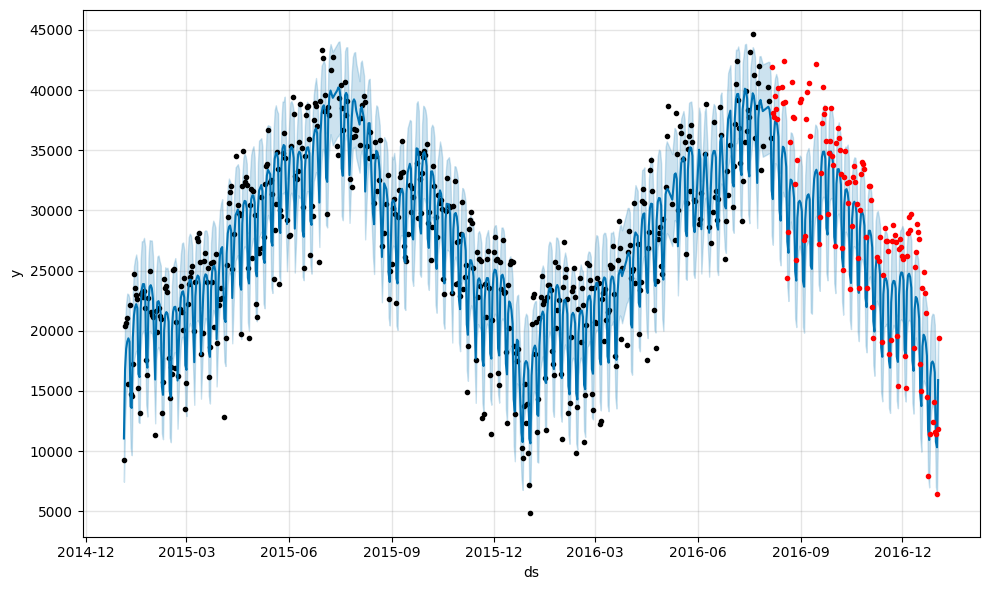

In [ ]:
fig1 = modelo_sem_outliers.plot(previsao)
plt.plot(test_df1['ds'], test_df1['y'], '.r')

plt.show()

Com esse artifício, conseguimos uma redução significativa no erro, o que pode resultar em uma melhora substancial na utilização do modelo no dia a dia. No entanto, é importante lembrar que essa abordagem nem sempre é viável ou adequada para todos os problemas que enfrentamos.

Existem diversas técnicas de substituição de outliers como:
* Substituição por estimativas;
* Truncagem;
* Transformações.

E sempre existe a possibilidade de usar modelos que sejam menos sensiveis a outliers.

### Aplicando o GridSearch

In [ ]:
from sklearn.model_selection import ParameterGrid

# Definindo os hiperparâmetros para o GridSearch
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'changepoint_range': [0.8, 0.9, 1.0],
    'n_changepoints': [5, 7, 10, 12, 25]
}

# Gerando combinações de parâmetros
all_params = list(ParameterGrid(param_grid))

# Definindo as métricas de avaliação
best_params = None
best_rmse = float('inf')

# Função para calcular o RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Loop através de cada combinação de parâmetros
for params in all_params:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        changepoint_range=params['changepoint_range'],
        n_changepoints=params['n_changepoints']
    )

    model.fit(train_df)  # Ajuste do modelo nos dados de treino
    forecast = model.predict(test_df)  # Previsões para os dados de teste

    # Calculando o RMSE
    rmse = calculate_rmse(test_df['y'], forecast['yhat'])

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

A saída de streaming foi truncada nas últimas 5000 linhas.
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99620', 'data', 'file=/tmp/tmplib0al6k/up2nyf8t.json', 'init=/tmp/tmplib0al6k/pkhbnssw.json', 'output', 'file=/tmp/tmplib0al6k/prophet_modelzfsu_9i1/prophet_model-20240602142057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/yk3xka7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0

In [ ]:
for i in best_params:
    print(i)

changepoint_prior_scale
changepoint_range
holidays_prior_scale
n_changepoints
seasonality_prior_scale


In [ ]:
print(f'Melhores parâmetros: {best_params}')
print(f'Melhor RMSE: {best_rmse}')

Melhores parâmetros: {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_prior_scale': 0.1}
Melhor RMSE: 8312.344961371331


In [ ]:
# Inicializa o modelo Prophet com os parâmetros
model_prophet = Prophet(yearly_seasonality=True,
                        changepoint_prior_scale=0.001,
                        changepoint_range=0.9,
                        holidays_prior_scale=0.001,
                        n_changepoints=10,
                        seasonality_prior_scale=0.1)

# Treina o modelo
model_prophet.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/oy4hkzqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/deuz5n3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66745', 'data', 'file=/tmp/tmplib0al6k/oy4hkzqb.json', 'init=/tmp/tmplib0al6k/deuz5n3e.json', 'output', 'file=/tmp/tmplib0al6k/prophet_model4bsp3sh0/prophet_model-20240602143815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Fazendo previsões para o período de teste
futuro = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')
previsao = model_prophet.predict(futuro)

In [ ]:
# Avaliando MSE e RMSE

df_previsao = previsao[['ds', 'yhat']]

df_comparacao = pd.merge(df_previsao, test_df, on='ds')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE:{mse}, RMSE:{rmse}')

MSE:32861895.226301253, RMSE:5732.529566107902


In [ ]:
# Calcular a média dos valores reais no conjunto de teste
mean_real_values = test_df['y'].mean()

# Calcular o RMSE (já calculado)
rmse = 5732.529566107902

# Calcular o erro percentual médio
mpe = (rmse / mean_real_values) * 100

print(f'Média dos valores reais: {mean_real_values}')
print(f'Erro Percentual Médio (MPE): {mpe:.2f}%')

Média dos valores reais: 28324.30821917808
Erro Percentual Médio (MPE): 20.24%


De 21.82% foi para 20.24% representando um ganho absoluto de 1.58%.

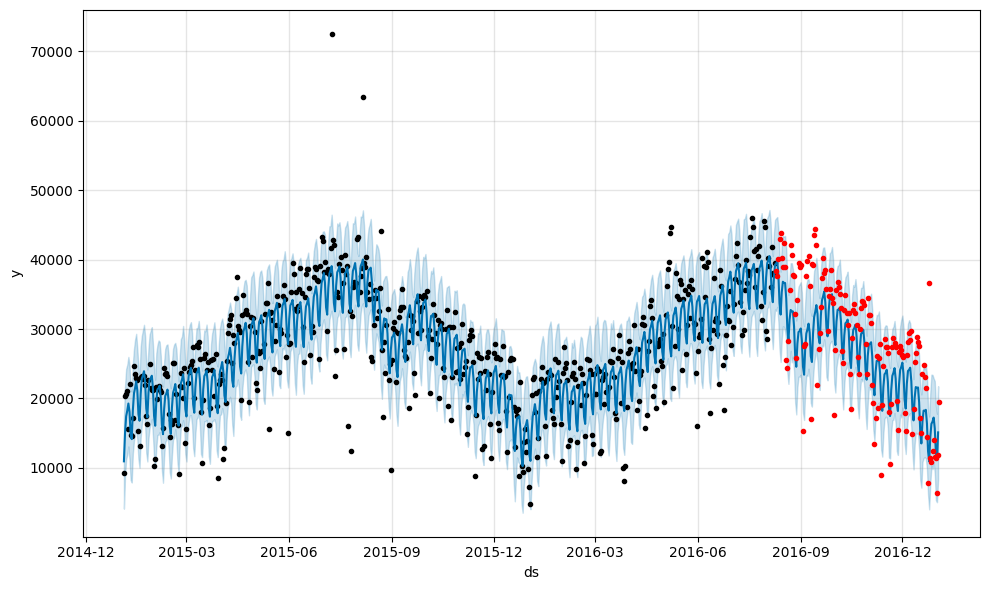

In [ ]:
fig1 = model_prophet.plot(previsao)
plt.plot(test_df['ds'], test_df['y'], '.r', label='Test Data')

plt.show()

### Cross validation

É sempre interessante fazer a validação cruzada para tirar a dependencia do numero aleatório que utilizamos no começo (42)

In [ ]:
df.shape

(730, 2)

 O parâmetro initial define o tamanho do conjunto de dados **inicial** para treinar o modelo antes de começar a validação cruzada. O **period** define com que frequência novos dados são adicionados ao conjunto de dados de treinamento. O **horizon** é o período de tempo para o qual as previsões são feitas em cada etapa da validação cruzada.

* initial: Este deve ser o tamanho do conjunto de dados que você deseja usar para treinar o modelo antes de iniciar a validação cruzada. No nosso caso, como decidi usar 180 pontos de dados para treinamento, porque é o periodo que o comportamento sazonal anual muda, então acredito que dê um resultado interessante olhar esse comportamento a cada 6 meses.

* period: Este parâmetro define a frequência com que a validação cruzada é realizada. Como queremos uma validação que pegue o comportamento de tendencia semestral, vamos usar 180 dias.

* horizon: Este é o período de tempo para o qual as previsões são feitas em cada etapa da validação cruzada. Vamos usar 30 dias de horizonte para entender como o RMSE muda conforme ele se distancia dos primeiros dias de predição.

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics


# Define os parâmetros para a validação cruzada
df_cv = cross_validation(model_prophet,
                         initial='180 days', #554  # o período inicial para treinar o modelo
                         period='180 days',#30   # a frequência com que a validação cruzada será realizada
                         horizon = '30 days')

# df_cv conterá o conjunto de dados de validação cruzada

INFO:prophet:Making 3 forecasts with cutoffs between 2015-07-16 00:00:00 and 2016-07-10 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/e2p8k0b1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/jbzvhs1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61143', 'data', 'file=/tmp/tmplib0al6k/e2p8k0b1.json', 'init=/tmp/tmplib0al6k/jbzvhs1t.json', 'output', 'file=/tmp/tmplib0al6k/prophet_modelo0l6f3qs/prophet_model-20240602152938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/yf5yn3p6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplib0al6k/w_de2d7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
print("RMSE: ", round(performance_metrics(df_cv)["rmse"].mean(),1))

RMSE:  10776.4


Temos um RMSE mais alto para o mês todo, mas vamos olhar o grafico a baixo para entender como o modelo se comportou durante o mÊs.

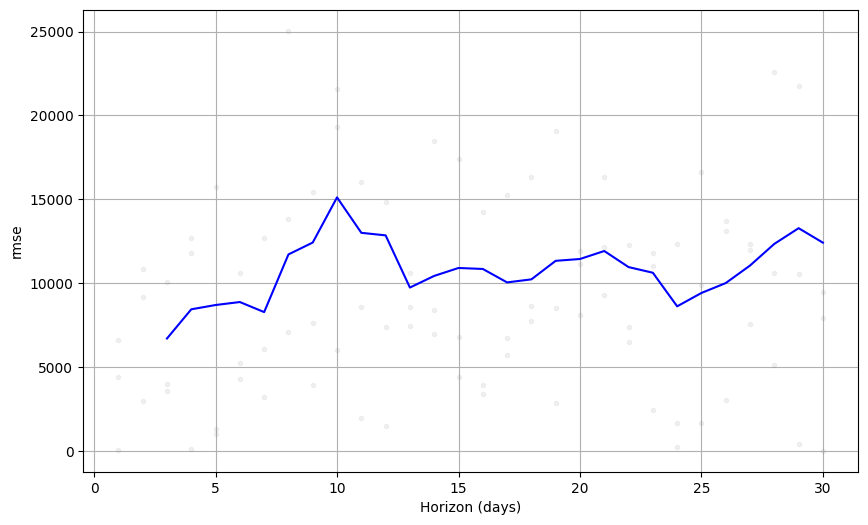

In [ ]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric = 'rmse');



* Flutuações no RMSE: As flutuações indicam que a precisão das previsões varia em diferentes pontos do horizonte de previsão. Isso pode ser devido a várias razões, como mudanças na tendência dos dados, eventos atípicos ou sazonalidades não capturadas pelo modelo.

* Aumento do RMSE: Se o RMSE aumenta com o horizonte, isso sugere que o modelo tem mais dificuldade em fazer previsões precisas para períodos mais distantes no futuro.

E para finalizar, é bastante intuitivo, mas importante mencionar que no D1 o gráfico apresenta um RMSE muito próximo do que obtivemos após a otimização dos hiperparâmetros. Portanto, é razoável que quanto mais distante dos dados que usamos para treinar o modelo, menos precisão teremos no modelo, e isso varia, mas, de modo geral, tende a aumentar o RMSE.

## Perfumaria

"E um parêntese importante em relação às possibilidades é que podemos analisar os gráficos que plotamos diversas vezes para entender os modelos, mas desta vez utilizando uma biblioteca interativa, como a Plotly! Essa abordagem pode auxiliar em algumas análises, especialmente quando precisamos dar zoom ou selecionar as variáveis que aparecem no gráfico de forma mais amigável.

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
plot_plotly(model_prophet, previsao)

In [ ]:
plot_components_plotly(model_prophet, previsao)